# La Palma Earthquakes

Steve Purves [](https://orcid.org/0000-0002-0760-5497) (Curvenote)  
Rowan Cockett [](https://orcid.org/0000-0002-7859-8394) (Curvenote)  
May 11, 2022

In September 2021, a significant jump in seismic activity on the island of La Palma (Canary Islands, Spain) signaled the start of a volcanic crisis that still continues at the time of writing. Earthquake data is continually collected and published by the Instituto Geográphico Nacional (IGN). We have created an accessible dataset from this and completed preliminary data analysis which shows seismicity originating at two distinct depths, consistent with the model of a two reservoir system feeding the currently very active volcano.

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Introduction

La Palma is one of the west most islands in the Volcanic Archipelago of the Canary Islands, a Spanish territory situated is the Atlantic Ocean where at their closest point are 100km from the African coast <a href="#fig-map" class="quarto-xref">Figure 1</a>. The island is one of the youngest, remains active and is still in the island forming stage.

![Figure 1: Map of La Palma in the Canary Islands. Image credit [NordNordWest](https://commons.wikimedia.org/w/index.php?curid=76638603)](attachment:images/la-palma-map.png)

La Palma has been constructed by various phases of volcanism, the most recent and currently active being the *Cumbre Vieja* volcano, a north-south volcanic ridge that constitutes the southern half of the island.

### Eruption History

A number of eruptions were recorded since the colonization of the islands by Europeans in the late 1400s, these are summarised in <a href="#tbl-history" class="quarto-xref">Table 1</a>.
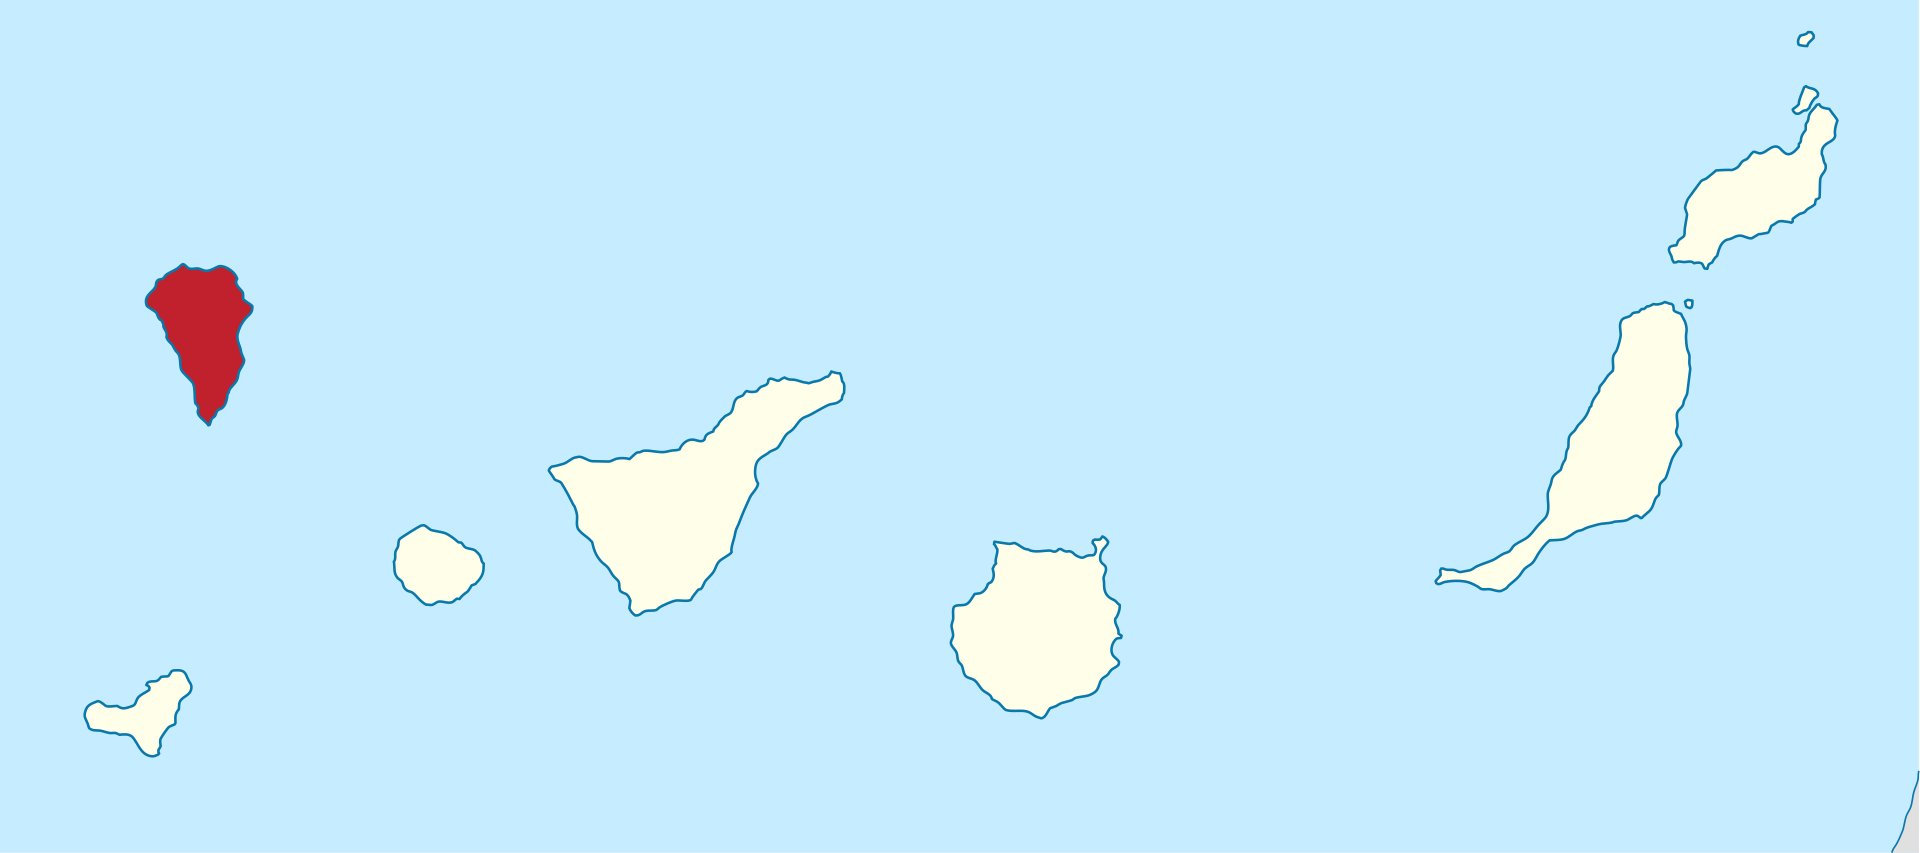

In [ ]:
eruptions <- tribble(
  ~ name, ~ year,
  "Current",             2021,
  "Teneguía",            1971,
  "Nambroque",           1949,
  "El Charco",           1712,
  "Volcán San Antonio",  1677,
  "Volcán San Martin",   1646,
  "Tajuya near El Paso", 1585,
  "Montaña Quemada",     1492,
)
n_eruptions <- nrow(eruptions)

In [ ]:
eruptions |> knitr::kable()

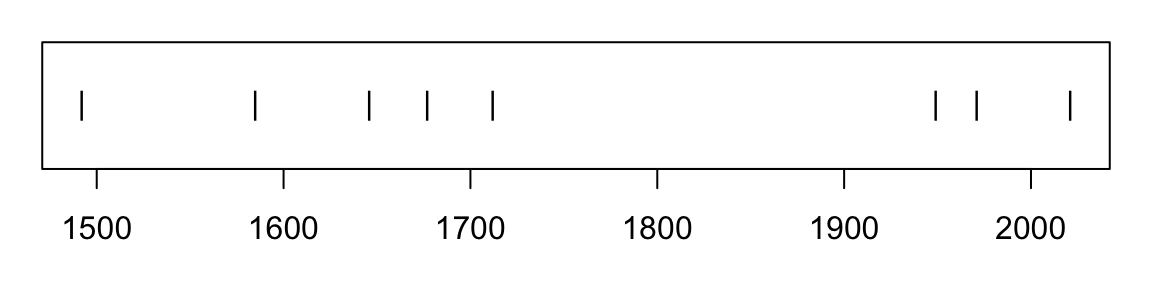

In [ ]:
par(mar = c(3, 1, 1, 1) + 0.1)
plot(eruptions$year, rep(0, n_eruptions), 
  pch = "|", axes = FALSE)
axis(1)
box()

In [ ]:
avg_years_between_eruptions <- eruptions |> slice(-1) |> 
  pull(year) |> diff() |> mean() 
avg_years_between_eruptions

[1] -79.83333

This equates to an eruption on average every -80 years up until the 1971 event. The probability of a future eruption can be modeled by a Poisson distribution <a href="#eq-poisson" class="quarto-xref">Equation 1</a>.

<span id="eq-poisson">$$
p(x)=\frac{e^{-\lambda} \lambda^{x}}{x !}
 \qquad(1)$$</span>

Where $\lambda$ is the number of eruptions per year, $\lambda=\frac{1}{79}$ in this case. The probability of a future eruption in the next $t$ years can be calculated by:

<span id="eq-probability">$$
p_e = 1-\mathrm{e}^{-t \lambda}
 \qquad(2)$$</span>

So following the 1971 eruption the probability of an eruption in the following 50 years — the period ending this year — was 0.469. After the event, the number of eruptions per year moves to $\lambda=\frac{1}{75}$ and the probability of a further eruption within the next 50 years (2022-2071) rises to 0.487 and in the next 100 years, this rises again to 0.736.

### Magma Reservoirs

Studies of the magma systems feeding the volcano, such as Marrero et al. ([2019](#ref-marrero2019)) has proposed that there are two main magma reservoirs feeding the Cumbre Vieja volcano; one in the mantle (30-40km depth) which charges and in turn feeds a shallower crustal reservoir (10-20km depth).

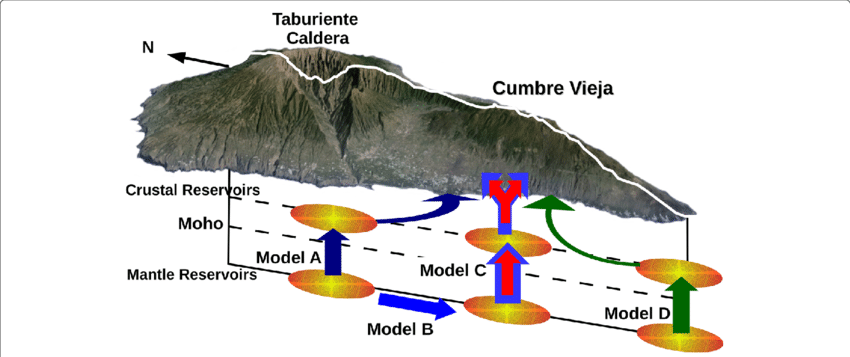

In this paper, we look at recent seismicity data to see if we can see evidence of such a system action, see <a href="#fig-reservoirs" class="quarto-xref">Figure 3</a>.

# Dataset

The earthquake dataset used in our analysis was generated from the [IGN web portal](https://www.ign.es/web/resources/volcanologia/tproximos/canarias.html) this is public data released under a permissive license. Data recorded using the network of Seismic Monitoring Stations on the island. A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.

## Visualising Long term earthquake data

Data taken directly from the IGN Catalog

``` python
from matplotlib import colormaps
cmap = colormaps['viridis_r']
ax = df.plot.scatter(x="Longitude", y="Latitude", 
                     s=40-df["Depth(km)"], c=df["Magnitude"], 
                     figsize=(12,10), grid="on", cmap=cmap)
colorbar = ax.collections[0].colorbar
colorbar.set_label("Magnitude")

plt.show()
```

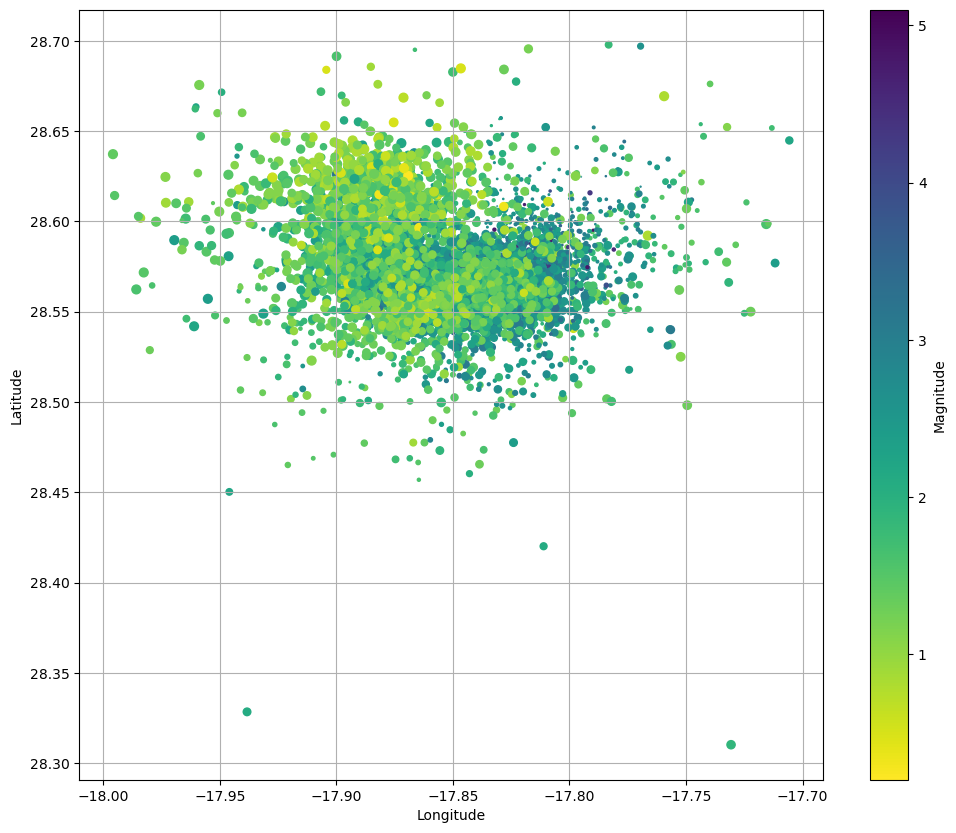

## Main Timeline Figure

``` python
eruption <- ymd_hms("2021-09-19 14:13:00")
date_axis_breaks <- as.Date("2021-10-15") + months(rep(0:2, each = 2)) - 
      days(rep(c(14, 0), times = 3))
date_axis_breaks <- c(eruption, date_axis_breaks[-1])

# Custom Magnitude Scale transform
trans_mag <- scales::trans_new(
  name = "Magnitude transformation",
  transform = \(x) 3*2^(1.3*x),
  inverse = \(x) (1/1.3) * log2(x/3)
)

  
df_erupt |>
  arrange(Magnitude) |> 
  ggplot(aes(DateTime, `Depth(km)`)) + 
  geom_point(aes(fill = Magnitude_categories, size = Magnitude,
    alpha = Magnitude_categories), shape = 21, color = "black") +
  geom_vline(xintercept = eruption, color = colors[7]) +
  annotate("text", x = eruption, y = 20, label = "ERUPTION", 
    color = colors[7], angle = 90, hjust = 1, vjust = -0.2, size = 6) +
  annotate("rect", xmin = epochs$start, xmax = epochs$end,
    ymin = -Inf, ymax = Inf, fill = colors[c(1, 3, 5, 7, 7)], alpha = 0.1) + 
  annotate("text", x =  epochs$start + 0.5*(epochs$end - epochs$start), y = -4, 
    label = epochs$text, color = colors[c(1, 3, 5, 7, NA)], size = 7) +
  scale_y_continuous("Depth (km)", trans = scales::reverse_trans(), 
    breaks = seq(0, 40, 10), limits = c( 45, -5), sec.axis = dup_axis()) +
  scale_x_datetime("Eruption Timeline", expand = c(0, 0), 
    date_labels = "%Y-%m-%d", breaks = date_axis_breaks) +
  scale_fill_manual("Event Magnitude (M)", values = colors[c(13, 17, 5, 3, 7)]) +
  scale_alpha_manual("Event Magnitude (M)", values = c(0.3, 0.4, 0.5, 0.6, 0.8)) +
  scale_size("Event Magnitude (M)", breaks = 1:5, labels = mag_labels, 
    trans = trans_mag) +
  theme_bw(base_size = 20, base_family = "Helvetica") + 
  theme(
    legend.position = c(0.01, 0.01), 
    legend.justification = c("left", "bottom"),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.border = element_blank(),
    axis.line.x.bottom = element_line(color = "grey50"),
    axis.title.y.right = element_blank(),
    plot.title = element_text(hjust = 0.5, margin = margin(t = 20, b = 20))
  ) +
  labs(title = "Recorded seismicity during the La Palma eruption 11 September - 15 December 2021 (INVOLCAN Dataset)")
```

    Warning: Removed 1 rows containing missing values (`geom_point()`).Warning: Removed 1 rows containing missing values (`geom_text()`).

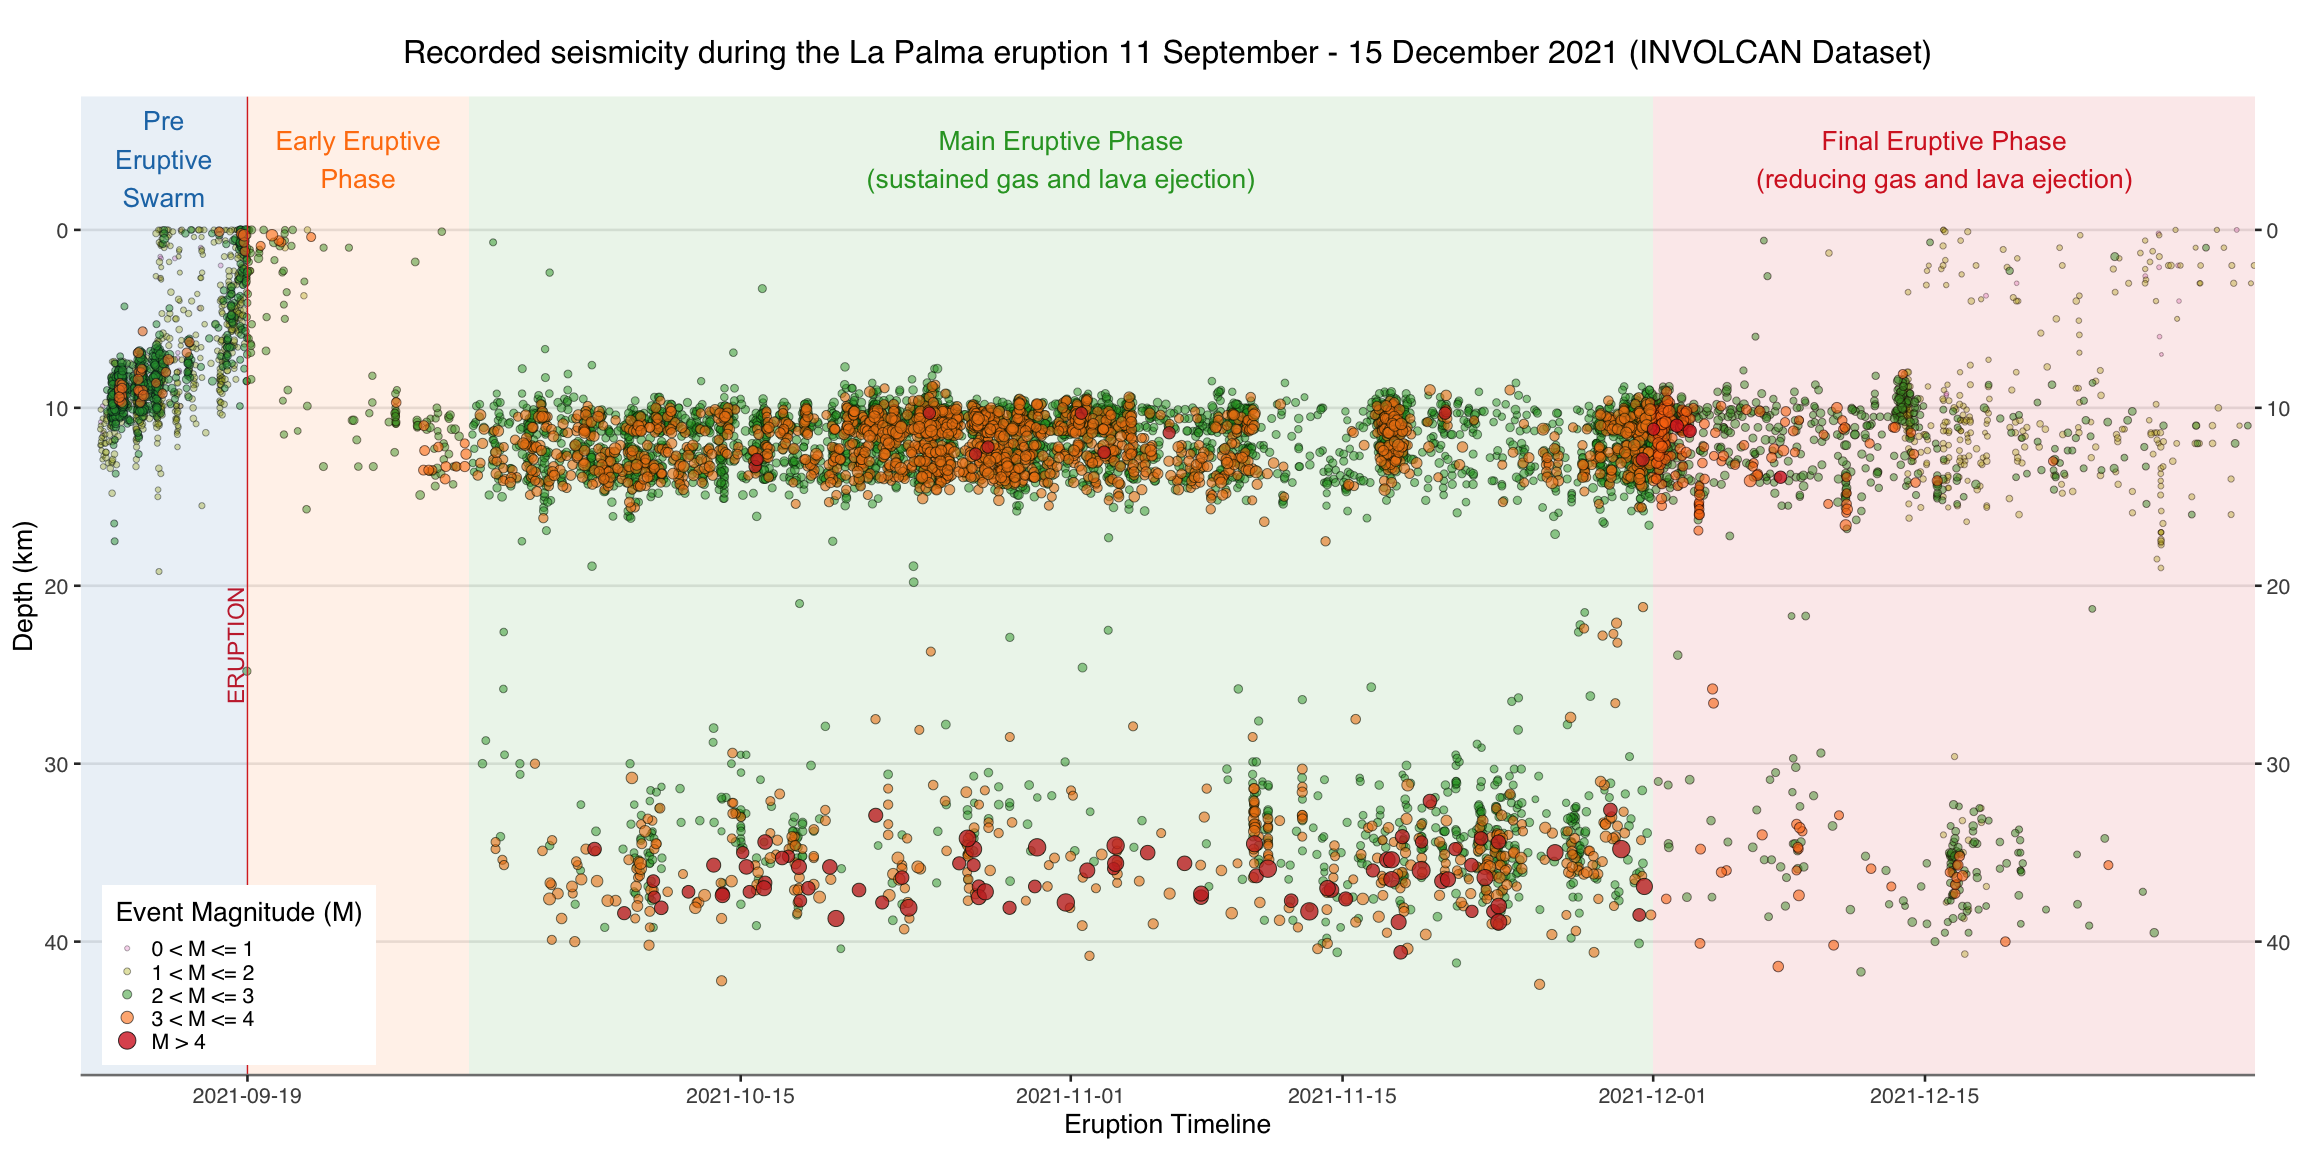

# Results

The dataset was loaded into this Jupyter notebook and filtered down to La Palma events only. This results in 5465 data points which we then visualized to understand their distributions spatially, by depth, by magnitude and in time.

From our analysis above, we can see 3 different systems in play.

Firstly, the shallow earthquake swarm leading up to the eruption on 19th September, related to significant surface deformation and shallow magma intrusion.

After the eruption, continuous shallow seismicity started at 10-15km corresponding to magma movement in the crustal reservoir.

Subsequently, high magnitude events begin occurring at 30-40km depths corresponding to changes in the mantle reservoir. These are also continuous but occur with a lower frequency than in the crustal reservoir.

# Conclusions

From the analysis of the earthquake data collected and published by IGN for the period of 11 September through to 9 November 2021. Visualization of the earthquake events at different depths appears to confirm the presence of both mantle and crustal reservoirs as proposed by Marrero et al. ([2019](#ref-marrero2019)).

A web scraping script was developed to pull data into a machine-readable form for analysis. That code tool [is available on GitHub](https://github.com/stevejpurves/ign-earthquake-data) along with a copy of recently updated data.

## References

Marrero, José, Alicia García, Manuel Berrocoso, Ángeles Llinares, Antonio Rodríguez-Losada, and R. Ortiz. 2019. “Strategies for the Development of Volcanic Hazard Maps in Monogenetic Volcanic Fields: The Example of La Palma (Canary Islands).” *Journal of Applied Volcanology* 8 (July). <https://doi.org/10.1186/s13617-019-0085-5>.